In [1]:
import numpy as np

# Create monkey patches
np.float = float
np.int = int
np.object = object
np.bool = bool

In [2]:
import librosa
import librosa.display
import seaborn as sns
import numpy as np
import utility_functions as utils
import importlib
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import warnings

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  # or RandomForestRegressor for regression tasks
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings("ignore", category=FutureWarning)
importlib.reload(utils)

/Users/borosabel/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


<module 'utility_functions' from '/Users/borosabel/Documents/Uni/Thesis/PopMIR/Code/Audio/utility_functions.py'>

In [4]:
def compute_features(row):
    audio_path = row['Path']
    features_dict = {}

    try:
        # Load audio file
        y, sr = librosa.load(audio_path)

        # MEL SPECTROGRAM FEATURES
        S = librosa.feature.melspectrogram(y=y, sr=sr)
        S_dB = librosa.power_to_db(S, ref=np.max)
        mel_mean = np.mean(S_dB, axis=1)
        mel_std = np.std(S_dB, axis=1)

        for i, (mean, std) in enumerate(zip(mel_mean, mel_std)):
            features_dict[f'Raw_Melspect_Mean_{i}'] = mean
            features_dict[f'Raw_Melspect_Std_{i}'] = std

        # MFCC FEATURES
        mfccs = librosa.feature.mfcc(y=y, sr=sr)
        delta_mfccs = librosa.feature.delta(mfccs)
        delta2_mfccs = librosa.feature.delta(mfccs, order=2)

        mfcc_means = np.mean(mfccs, axis=1)
        mfcc_stds = np.std(mfccs, axis=1)
        delta_mfccs_means = np.mean(delta_mfccs, axis=1)
        delta2_mfccs_means = np.mean(delta2_mfccs, axis=1)
        delta_mfccs_stds = np.std(delta_mfccs, axis=1)
        delta2_mfccs_stds = np.std(delta2_mfccs, axis=1)

        for i, (mean, std, delta_mean, delta_std, delta2_mean, delta2_std) in enumerate(zip(
                mfcc_means, mfcc_stds, delta_mfccs_means, delta_mfccs_stds, delta2_mfccs_means, delta2_mfccs_stds)):
            features_dict[f'Raw_MFCC_Mean_{i}'] = mean
            features_dict[f'Raw_MFCC_Std_{i}'] = std
            features_dict[f'Delta_MFCC_Mean_{i}'] = delta_mean
            features_dict[f'Delta_MFCC_Std_{i}'] = delta_std
            features_dict[f'Delta2_MFCC_Mean_{i}'] = delta2_mean
            features_dict[f'Delta2_MFCC_Std_{i}'] = delta2_std

        # Additional Features
        # Utilize utility functions to calculate additional features
        features_dict.update({
            'brightness': utils.calculate_brightness(y, sr),
            'band_energy': utils.band_energy(y, sr),
            'envelope_flatness': utils.envelope_flatness(y),
            'envelope_kurtosis': utils.envelope_kurtosis(y),
            'envelope_quantile_range': utils.calculate_envelope_quantile_range(y),
            'harmonic_energy': utils.calculate_harmonic_energy(y),
            'harmonic_percussive_ratio': utils.calculate_harmonic_percussive_ratio(y),
            'high_frequency_ratio': utils.calculate_high_frequency_ratio(y, sr),
            'loudness_sone': utils.calculate_loudness_sone(audio_path),
            'low_energy': utils.calculate_low_energy(y),
            'max_rms_position': utils.find_max_rms_position(y, sr),
            'max_rms_value': utils.find_max_rms_value(y),
            'segments_based_on_rms': utils.count_segments_based_on_rms(y),
            'percussive_energy': utils.calculate_percussive_energy(y),
            'mean_rms_energy': utils.calculate_average_rms_energy(y),
            'mean_average_spectral_centroid': utils.calculate_average_spectral_centroid(y, sr),
            'spectral_entropy': utils.calculate_spectral_entropy(y),
            'spectral_flatness': utils.average_calculate_spectral_flatness(y),
            'zero_crossing_rate': utils.zero_crossing_rate(y)  # This needs to be defined similarly in your utils
        })

    except Exception as e:
        print(f"Failed to process: {audio_path}")
        print(e)
        # features_dict['error'] = str(e)  # You might want to return an error indicator

    return pd.Series(features_dict)

In [5]:
tqdm.pandas(desc="Computing features")
result = df.progress_apply(compute_features, axis=1)

Computing features:   0%|          | 0/1368 [00:00<?, ?it/s]

In [44]:
# Here I am just loading the saved progress because calculating everything would take like 2 days but above you can see the utility functions I used to calculate the features.
df = pd.read_excel('/Users/borosabel/Documents/Uni/Thesis/PopMIR/Code/Audio/baseline_data.xlsx', engine='openpyxl')

In [45]:
# Here I am just loading the saved progress because calculating everything would take like 2 days but above you can see the utility functions I used to calculate the features.
features = pd.read_excel('/Users/borosabel/Documents/Uni/Thesis/PopMIR/Code/Audio/output.xlsx', engine='openpyxl')

In [52]:
le = LabelEncoder()
labels = pd.DataFrame(le.fit_transform(df['Coast']))

In [86]:
features.drop('Unnamed: 0', axis=1, inplace=True)

In [95]:
features['Tempo'] = df['Tempo1']

In [102]:
features.to_excel('hardness_features.xlsx', index=False)

In [97]:
k = 10
# I use StratifiedKFold to keep the balance of the dataset consistent.
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

Folds: 100%|██████████| 5/5 [14:28<00:00, 173.61s/it]

Best parameters found:  {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}
Cumulative Confusion Matrix:
[[531. 171.]
 [189. 477.]]
Average F1 Score: 0.7360056728576334


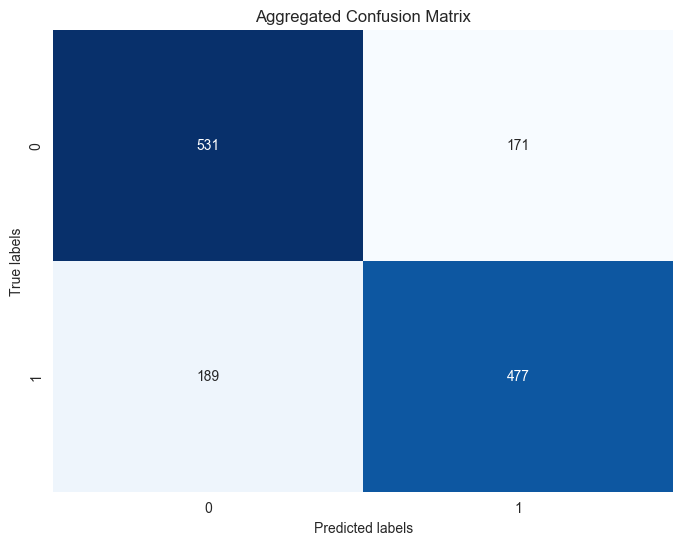

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score
from tqdm import tqdm

# Initialize your model
model = RandomForestClassifier(random_state=42)

# List to store each fold's F1 score
f1_scores = []

# Initialize an empty array to hold the sum of all confusion matrices
cumulative_conf_matrix = np.zeros((2, 2))  # Adjust the size if not binary classification

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Setup Grid Search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=0)

# Assuming 'features' and 'labels' are defined, and 'skf' is your StratifiedKFold instance
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)  # Example definition

# Split your data and use tqdm for the progress bar
for train_index, test_index in tqdm(skf.split(features, labels), total=skf.get_n_splits(), desc="Folds"):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]

    y_train = np.ravel(y_train)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_model = grid_search.best_estimator_

    # Predict using the best model
    y_pred = best_model.predict(X_test)

    # Compute the confusion matrix and add it to the cumulative matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    cumulative_conf_matrix += conf_mat

    # Calculate F1 score and append to list
    f1 = f1_score(y_test, y_pred, average='macro')  # Change 'macro' as needed for your classification scheme
    f1_scores.append(f1)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Print the cumulative confusion matrix
print("Cumulative Confusion Matrix:")
print(cumulative_conf_matrix)

# Print average F1 score
print("Average F1 Score:", np.mean(f1_scores))

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cumulative_conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Aggregated Confusion Matrix')
plt.show()

In [99]:
from sklearn.metrics import classification_report
from tqdm import tqdm
import numpy as np

best_model = RandomForestClassifier(random_state=42, **grid_search.best_params_)

skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
all_y_pred = []
all_y_test = []

for train_index, test_index in tqdm(skf.split(features, labels), total=skf.get_n_splits(), desc="Folds"):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]

    y_train = np.ravel(y_train)

    best_model.fit(X_train, y_train)
    
    y_pred = best_model.predict(X_test)
    y_test = np.ravel(y_test.to_numpy())
    all_y_pred.extend(y_pred)
    all_y_test.extend(y_test)

print("Length of all_y_test:", len(all_y_test))
print("Length of all_y_pred:", len(all_y_pred))

print("Classification Report:")
print(classification_report(all_y_test, all_y_pred))

Folds: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]

Length of all_y_test: 1368
Length of all_y_pred: 1368
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.74      0.73       702
           1       0.72      0.70      0.71       666

    accuracy                           0.72      1368
   macro avg       0.72      0.72      0.72      1368
weighted avg       0.72      0.72      0.72      1368


In [100]:
importances = best_model.feature_importances_
feature_names = features.columns
feature_importance_dict = dict(zip(feature_names, importances))

# Optionally, convert to a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print(importance_df)

                     Feature  Importance
0        Raw_Melspect_Mean_0    0.020104
396                    Tempo    0.015028
328         Raw_MFCC_Mean_12    0.013482
387            max_rms_value    0.013223
380  envelope_quantile_range    0.010872
..                       ...         ...
135      Raw_Melspect_Std_67    0.000791
65       Raw_Melspect_Std_32    0.000788
143      Raw_Melspect_Std_71    0.000658
81       Raw_Melspect_Std_40    0.000638
122     Raw_Melspect_Mean_61    0.000508

[397 rows x 2 columns]


In [101]:
importance_df.head(10)

,Feature,Importance
0,Raw_Melspect_Mean_0,0.020104
396,Tempo,0.015028
328,Raw_MFCC_Mean_12,0.013482
387,max_rms_value,0.013223
380,envelope_quantile_range,0.010872
2,Raw_Melspect_Mean_1,0.010856
388,segments_based_on_rms,0.010114
346,Raw_MFCC_Mean_15,0.008836
340,Raw_MFCC_Mean_14,0.007660
384,loudness_sone,0.007150
